This notebook allows you to train and run the stochastic follow-up EF model presented here (https://ecs193-final-project.herokuapp.com/). In order to run this code, you will need have the cleaned data downloaded. This data is located here: https://drive.google.com/file/d/1ecNmerBZLMQlaWnoyNkE4bZrHPV8gkoL/view?usp=sharing

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import sklearn
import keras
import tensorflow as tf
import operator
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import itertools
from keras import backend as K
from time import time
from keras.utils import plot_model
from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_auc_score,roc_curve,recall_score,precision_score,f1_score
from datetime import datetime, date
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Embedding, LSTM, Dropout, Dropout
from keras.models import Model
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


Here, we clean up the the .csv files downloaded. In particular, a lot of column values have no values, so we impute them with np.nan so they can be zero filled later.

In [0]:
df2 = pd.read_csv("combined_echo_data_new.csv")
df2 = df2.drop("Unnamed: 0",axis=1)
df2 = df2.dropna(axis=0,subset = ["Pt. ID"])
exclude_mrns = []

for ids in np.array(df2['Pt. ID'].unique()):
  try:
    ids1 = int(ids) 
  except ValueError:
    exclude_mrns.append(ids)

df2 = df2[~df2['Pt. ID'].isin(exclude_mrns)]
df2['Pt. ID'] = df2['Pt. ID'].astype(int)

vol, ef = [], []  # Created new cols

for index, record in df2.iterrows():
  volume_A4C = record["LA Vol A/L A4C i BSA"]
  volume_A2C = record["LA Vol A/L A2C i BSA"]
  volume_BP =  record["LA Vol A/L BP i BSA"]
  ef_A4C = record["LV EF, MOD A4C"]
  ef_A2C = record["LV EF, MOD A2C"]
  ef_BP = record["LV EF, MOD BP"]
  # First pick is the A4C channel
  if not np.isnan(volume_A4C):
    vol.append(volume_A4C)
  # Next pick is from A2C channel
  elif not np.isnan(volume_A2C):
    vol.append(volume_A2C)
  # Worst case, choose from BP channel
  elif not np.isnan(volume_BP):
    vol.append(volume_BP)
  # If all channels are empty; set it empty
  else:
    vol.append(float("nan"))
  
  # Do the same for EF
  if not np.isnan(ef_A4C):
    ef.append(ef_A4C) 
  elif not np.isnan(ef_A2C):
    ef.append(ef_A2C) 
  elif not np.isnan(ef_BP):
    ef.append(ef_BP) 
  else:
    ef.append(float("nan"))

df2["LA Vol A/L Volume"] = vol # New column for Volume added
df2["Ejection_Fraction"] = ef  # New column for EF added
df2 = df2.drop(["LA Vol A/L A4C i BSA","LA Vol A/L A2C i BSA",
                "LA Vol A/L BP i BSA","LV EF, MOD A4C",
                "LV EF, MOD A2C","LV EF, MOD BP"], axis=1) # Drop these obsolete cols
df2 = df2.dropna(axis = 0, how="all",subset=["Ejection_Fraction"])
ind = df2[df2['Ejection_Fraction'] <= 0].index.tolist() + df2[df2['IVS d, 2D'] > 5].index.tolist() 
ind = ind + df2[df2['LV d, 2D'] > 10].index.tolist() + df2[df2['LV s, 2D'] > 10].index.tolist() 
ind += df2[df2['RVSP (TR)'] > 125].index.tolist() + df2[df2['LA Vol A/L Volume'] > 200].index.tolist()
df_echo = df2.drop(ind,axis=0)

We also need to zero fill any np.nan values and normalize.

In [0]:
zero_filled_values = np.nan_to_num(df_echo[df_echo.columns.to_list()[2:]].values)
prior_values = df_echo[df_echo.columns.to_list()[0:2]].values
all_values = np.append(prior_values, zero_filled_values, axis=1)

df_echo_norm = pd.DataFrame(all_values,columns=df_echo.columns.to_list())

# normalizing the values
df_echo_norm['IVS d, 2D'] = df_echo_norm['IVS d, 2D'] / 5.0
df_echo_norm['LV d, 2D'] = df_echo_norm['LV d, 2D'] / 10.0
df_echo_norm['LV s, 2D'] = df_echo_norm['LV s, 2D'] / 10.0
df_echo_norm['RVSP (TR)'] = df_echo_norm['RVSP (TR)'] / 125.0
df_echo_norm['LA Vol A/L Volume'] = df_echo_norm['LA Vol A/L Volume'] / 200.0
df_echo_norm['Ejection_Fraction'] = df_echo_norm['Ejection_Fraction'] / 100.0

Now, we collect the follow-up EF samples using the data from the EF sample. We check to see if there is a follow-up EF sample 90-365 days following the initial EF date. 

In [6]:
from tqdm import tqdm

date_format = "%Y-%m-%d %H:%M:%S"

x_values = None
y_values = None

groups = df_echo_norm.groupby(by="Pt. ID")

for grp_name, record in tqdm(groups):
  sorted_record = record.sort_values(['Study Date'])
  sorted_record['Study Date'] = pd.to_datetime(sorted_record['Study Date'])
  for i in range(len(sorted_record)):
    for j in range(i+1,len(sorted_record)):
      mrn = sorted_record.iloc[i]['Pt. ID']
      initial_echo_date = sorted_record.iloc[i]['Study Date']
      end_echo_date = sorted_record.iloc[j]['Study Date']

      delta = (end_echo_date - initial_echo_date).days

      if delta > 90 and delta < 365:
        input_indices = [0, 2, 3, 4, 5, 6, 7]
        data_input = [sorted_record.iloc[i].values[input_indices]]
        data_output = [[sorted_record.iloc[j]['Ejection_Fraction']]]
        if x_values is None:
          x_values =  data_input
          y_values = data_output
        else:
          x_values = np.append(x_values, data_input, axis=0)
          y_values = np.append(y_values, data_output)

100%|██████████| 35627/35627 [01:31<00:00, 389.13it/s]


Now, we will undersample the data so there is an equal balance of data of data points where EF < 0.35 and EF >= 0.35.

In [0]:
def undersample(X, y, threshold):
  assert (len(X) == len(y)), "lengths of X and y are not equal"
  X_low = None
  X_high = None
  y_low = None
  y_high = None

  for i in range(len(y)):
    if y[i] < threshold:
      if X_low is None:
        X_low = [X[i]]
        y_low = y[i]
      else:
        X_low = np.append(X_low, [X[i]], axis=0)
        y_low = np.append(y_low, y[i])
    else:
      if X_high is None:
        X_high = [X[i]]
        y_high = y[i]
      else:
        X_high = np.append(X_high, [X[i]],axis=0)
        y_high = np.append(y_high, y[i])

  if len(y_low) < len(y_high):
    chosen = np.random.choice(len(y_high), len(y_low), replace=False)
    X_high = X_high[chosen]
    y_high = y_high[chosen]
  else:
    chosen = np.random.choice(len(y_low), len(y_high), replace=False)
    X_low = X_low[chosen]
    y_low = y_low[chosen]

  X_new = np.append(X_low, X_high, axis=0)
  y_new = np.append(y_low, y_high)
  X_new, y_new = shuffle(X_new, y_new, random_state=0)

  return X_new, y_new

In [0]:
x_values, y_values = undersample(x_values, y_values, 0.35)

In [0]:
all_training_data = np.append(x_values, np.expand_dims(y_values, axis=1), axis=1)
df_final_training_data = pd.DataFrame(all_training_data,
                                      columns=["Pt. ID", "IVS d, 2D",	"LV d, 2D",	
                                                "LV s, 2D",	"RVSP (TR)",	"LA Vol A/L Volume", 
                                                "Ejection_Fraction",	"Ejection_Fraction_Followup"])

We need to make sure we split by individual patients so same patients are not in both train and test.

In [0]:
ids = df_final_training_data["Pt. ID"].unique() # Get all the different patients

We'll do uncertainty estimation here. First, we need to instantiate a stochastic model.

In [0]:
class StochasticModel(keras.Model):
  def __init__(self):
    super(StochasticModel, self).__init__()

    self.layer_1 = Dense(100, activation='relu')
    self.dropout_1 = Dropout(0.5)

    self.layer_2 = Dense(50, activation='relu')
    self.dropout_2 = Dropout(0.5)
    
    self.layer_3 = Dense(10, activation='relu')
    self.dropout_3 = Dropout(0.5)

    self.output_layer = Dense(1, activation='sigmoid')
  
  def call(self, x):
    x = self.layer_1(x)
    x = self.dropout_1(x, training=True)

    x = self.layer_2(x)
    x = self.dropout_2(x, training=True)

    x = self.layer_3(x)
    x = self.dropout_3(x, training=True)

    output = self.output_layer(x)

    return output

In [0]:
x_data = df_final_training_data[df_final_training_data.columns.to_list()[:-1]].values
y_data = df_final_training_data[df_final_training_data.columns.to_list()[-1]].values

We will split by patient IDs here and create the train and test sets ready for model input.

In [0]:
train_ids, test_ids = train_test_split(ids, test_size = 0.10)

In [0]:
df_train = df_final_training_data[df_final_training_data["Pt. ID"].isin(train_ids)]
df_test = df_final_training_data[df_final_training_data["Pt. ID"].isin(test_ids)]

In [0]:
x_train = df_train[df_final_training_data.columns.to_list()[1:-1]].values
y_train = df_train[df_final_training_data.columns.to_list()[-1]].values

In [0]:
x_test = df_test[df_final_training_data.columns.to_list()[1:-1]].values
y_test = df_test[df_final_training_data.columns.to_list()[-1]].values

In [22]:
batch_size = 1000
epochs = 50
adam = Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def mse_loss(y_actual, y_pred):
	return K.mean(K.square(y_pred - y_actual))

In [0]:
stochastic_model = StochasticModel()
stochastic_model.compile(loss=mse_loss, optimizer=adam, metrics=[mse_loss])

In [0]:
stochastic_model.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_test, y_test), epochs = 100)

Some helper functions.

In [0]:
def binarize_output(output,limit = 0.35):
  processed_output = []
  for elem in output:
    if elem < limit:
      processed_output.append(0)
    else:
      processed_output.append(1)
  
  return processed_output

In [0]:
def basic_accuracy_metric(y_pred, y_truth):
  count = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_truth[i]:
      count = count + 1
  return count * 100.00/ len(y_pred)

In [0]:
y_test_binarized = binarize_output(y_test)
stochastic_model_preds = binarize_output(stochastic_model.predict(x_test))

Here, the run through every test point in the dataset and perform inference on in N (20 in this setting times). We use the mean as the prediction of the model and the variance as a measure of uncertainty.

In [38]:
from tqdm import tqdm

correct_pred_uncertainties_negative = []
correct_pred_uncertainties_positive = []

incorrect_pred_uncertainties_negative = []
incorrect_pred_uncertainties_positive = []

correct_pred_mean_negative = []
correct_pred_mean_positive = []

incorrect_pred_mean_negative = []
incorrect_pred_mean_positive = []

all_predictions = []
all_uncertainties = []

num_samples_per_example = 100 # hyperparameter that can be changed

for i in tqdm(range(len(x_test))): # iterating through every example
  ground_truth = y_test_binarized[i]
  sample_predictions = []
  for j in range(num_samples_per_example):
    sample_prediction = stochastic_model.predict(np.expand_dims(x_test[i], axis=0))[0][0]
    sample_predictions.append(sample_prediction)
  
  sample_predictions = np.array(sample_predictions)

  raw_prediction_mean = np.mean(sample_predictions)
  raw_prediction_variance = np.var(sample_predictions) # measure of uncertainty, un-binarized

  all_predictions.append(raw_prediction_mean)
  all_uncertainties.append(raw_prediction_variance)

  if raw_prediction_mean < 0.35:
    prediction_mean = 0
  else:
    prediction_mean = 1

  if prediction_mean == ground_truth:
    if prediction_mean == 0:
      correct_pred_uncertainties_negative.append(raw_prediction_variance)
      correct_pred_mean_negative.append((raw_prediction_mean, y_test[i]))
    else:
      correct_pred_uncertainties_positive.append(raw_prediction_variance)
      correct_pred_mean_positive.append((raw_prediction_mean, y_test[i]))
  else:
    if prediction_mean == 0:
      incorrect_pred_uncertainties_negative.append(raw_prediction_variance)
      incorrect_pred_mean_negative.append((raw_prediction_mean, y_test[i]))
    else:
      incorrect_pred_uncertainties_positive.append(raw_prediction_variance)
      incorrect_pred_mean_positive.append((raw_prediction_mean, y_test[i]))

100%|██████████| 314/314 [00:21<00:00, 14.79it/s]


Next, we will produce the uncertainty estimate plots.

In [0]:
correct_negative_errors = []
correct_positive_errors = []

incorrect_negative_errors = []
incorrect_positive_errors = []

for (prediction, ground_truth) in correct_pred_mean_negative:
  correct_negative_errors.append(abs(prediction - ground_truth))

for (prediction, ground_truth) in correct_pred_mean_positive:
  correct_positive_errors.append(abs(prediction - ground_truth))

for (prediction, ground_truth) in incorrect_pred_mean_negative:
  incorrect_negative_errors.append(abs(prediction - ground_truth))

for (prediction, ground_truth) in incorrect_pred_mean_positive:
  incorrect_positive_errors.append(abs(prediction - ground_truth))

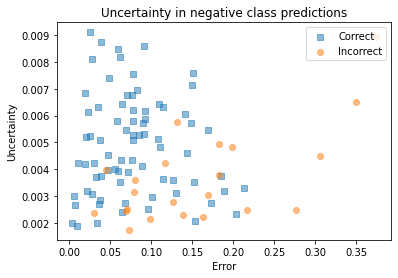

In [40]:
plt.title("Uncertainty in negative class predictions")
plt.xlabel("Error")
plt.ylabel("Uncertainty")
plt.scatter(correct_negative_errors, correct_pred_uncertainties_negative, marker="s", label='Correct', alpha=0.5)
plt.scatter(incorrect_negative_errors, incorrect_pred_uncertainties_negative, marker="o", label='Incorrect', alpha=0.5)
plt.legend(loc='upper right');
plt.show()

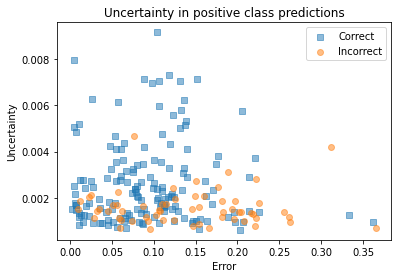

In [41]:
plt.title("Uncertainty in positive class predictions")
plt.xlabel("Error")
plt.ylabel("Uncertainty")
plt.scatter(correct_positive_errors, correct_pred_uncertainties_positive, marker="s", label='Correct', alpha=0.5)
plt.scatter(incorrect_positive_errors, incorrect_pred_uncertainties_positive, marker="o", label='Incorrect', alpha=0.5)
plt.legend(loc='upper right');
plt.show()

We finally need to save the model for future. 

In [0]:
stochastic_model.save_weights('stochastic_model_weights.tf')

And some code to show you how to load this model and use it.

In [0]:
def return_loaded_model():
  loaded_model = StochasticModel()
  loaded_model.compile(loss=mse_loss, optimizer=adam, metrics=[mse_loss])
  loaded_model.predict(np.zeros((1, 6)))
  loaded_model.load_weights('stochastic_model_weights.tf')
  return loaded_model